In [12]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load CSV file

df = pd.read_csv("/home/fschumann/Downloads/dielectron.csv")

df.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


In [3]:
# Binary Label for Z Candidate

df["label"] = ((df["M"] >= 80) & (df["M"] <= 100)).astype(int)
print(df["label"].value_counts())

label
0    92064
1     7936
Name: count, dtype: int64


In [7]:
df["delta_eta"] = df["eta1"] - df["eta2"]
df["delta_phi"] = df["phi1"] - df["phi2"]
df["pt_ratio"] = df["pt1"] / (df["pt2"] + 1e-6)

In [8]:
# Features and Labels

features = [
    "E1","px1 ","py1","pz1","pt1","eta1","phi1","Q1",
    "E2","px2","py2","pz2","pt2","eta2","phi2","Q2",
    "delta_eta","delta_phi","pt_ratio"
]

X = df[features]
y = df["label"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural networks train faster and converge better with normalized inputs.

In [14]:
# Neural network architecture

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')  # Binary output
])

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Train model

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# EarlyStopping: stops training if validation loss does not improve for 10 epochs

# validation_split=0.2: uses 20% of training data to monitor performance

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9235 - loss: 0.1975 - val_accuracy: 0.9654 - val_loss: 0.0858
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9602 - loss: 0.0992 - val_accuracy: 0.9684 - val_loss: 0.0684
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9634 - loss: 0.0839 - val_accuracy: 0.9719 - val_loss: 0.0627
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9668 - loss: 0.0770 - val_accuracy: 0.9733 - val_loss: 0.0598
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9690 - loss: 0.0705 - val_accuracy: 0.9728 - val_loss: 0.0569
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9712 - loss: 0.0666 - val_accuracy: 0.9755 - val_loss: 0.0526
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9720 - loss: 0.0634 - val_accuracy: 0.9780 - val_loss: 0.0524
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9741 - loss: 0.0604 - val_accu

As we can see, training stopped after 54 epochs.

In [18]:
# Evaluate model

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.98655

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     18413
           1       0.87      0.97      0.92      1587

    accuracy                           0.99     20000
   macro avg       0.93      0.98      0.96     20000
weighted avg       0.99      0.99      0.99     20000


Confusion Matrix:
 [[18185   228]
 [   41  1546]]


Starting with a simple baseline model, we were already able to score a 98.7% in prediction accuracy. Pretty good!

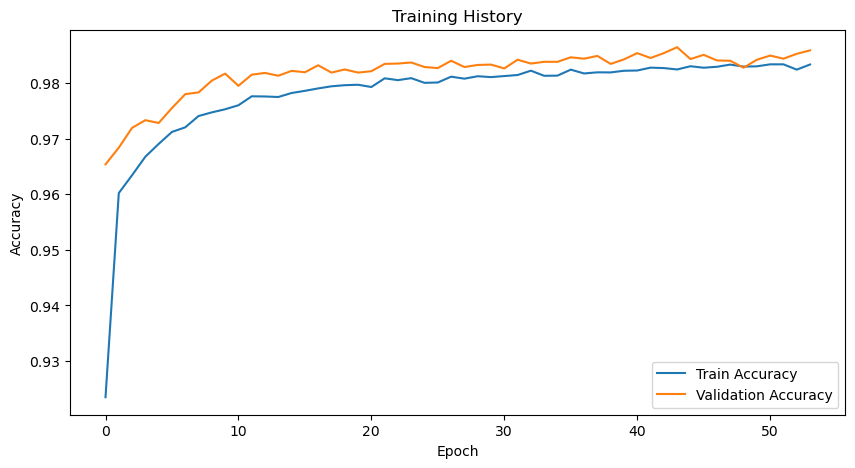

In [19]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

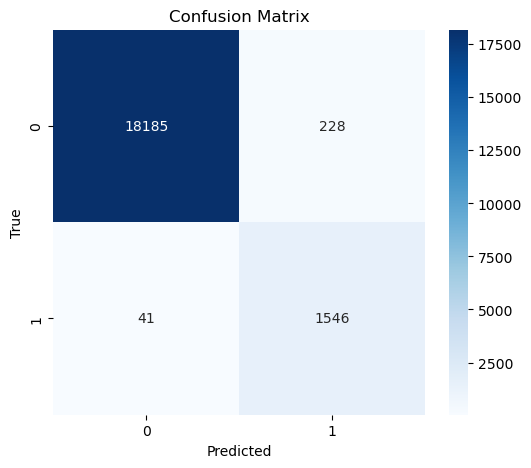

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


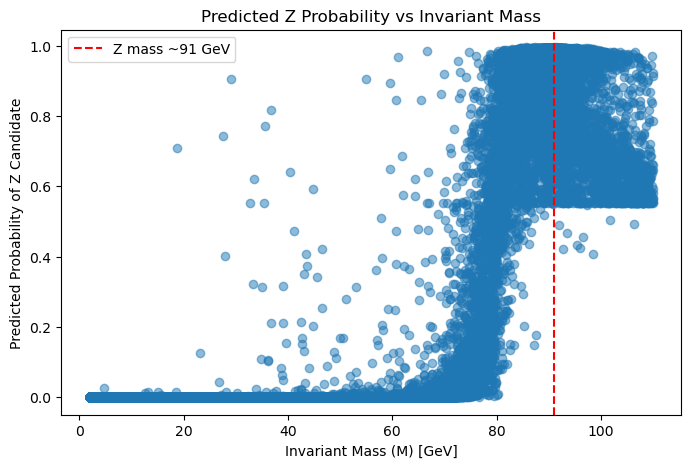

In [21]:
plt.figure(figsize=(8,5))
plt.scatter(df['M'], model.predict(scaler.transform(df[features])), alpha=0.5)
plt.xlabel('Invariant Mass (M) [GeV]')
plt.ylabel('Predicted Probability of Z Candidate')
plt.title('Predicted Z Probability vs Invariant Mass')
plt.axvline(91, color='red', linestyle='--', label='Z mass ~91 GeV')
plt.legend()
plt.show()

## Results and accuracy

The final neural network achieved 98.7% classification accuracy on the held-out test set when identifying Z boson candidate events within the invariant mass window (80–100 GeV).

This project shows that even a fairly straightforward neural network, when combined with some feature engineering, can perform well on collider data. That said, there’s definitely room to push it further. Some next steps could be:

- Building benchmark models for comparison

- Evaluating the model on independent CMS datasets